In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import seaborn as sns
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
cars_file = 'https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv'
cars = pd.read_csv(cars_file)
cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


<AxesSubplot:xlabel='wt', ylabel='mpg'>

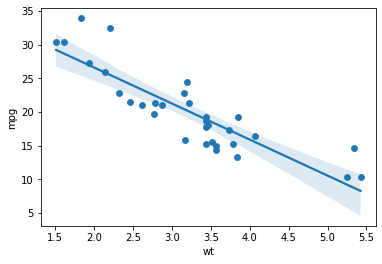

In [3]:
sns.scatterplot(x='wt', y='mpg', data=cars)
sns.regplot(x='wt', y='mpg', data=cars)

In [4]:
X_list = cars.wt.values
X_np = np.array(X_list, dtype=np.float32).reshape(-1,1)
y_list = cars.mpg.values
y_np = np.array(y_list, dtype=np.float32).reshape(-1,1)
X = torch.from_numpy(X_np)
y_true = torch.from_numpy(y_np)

In [5]:
class LinearRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
train_loader = DataLoader(dataset = LinearRegressionDataset(X_np, y_np), batch_size=2)


In [7]:
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super(LinearRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

input_dim = 1
output_dim = 1
model = LinearRegressionTorch(input_size=input_dim, output_size=output_dim)
model.train()

LinearRegressionTorch(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [9]:
loss_fun = nn.MSELoss()

learning_rate = 0.02
# test different values of too large 0.1 and too small 0.001
# best 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# FOR HYPERPARAMETER TUNING: SKORCH, Ray-Tune ,Optuna
net  = NeuralNetRegressor( LinearRegressionTorch,
                           max_epochs=100,
                           lr = learning_rate,
                           iterator_train__shuffle = True)

net.set_params(train_split=False, verbose=0)
params = {'lr':[0.02,0.05,0.08],
          'max_epochs':[10,200,500]}

gs = GridSearchCV(net,params,scoring="r2", cv=3, verbose=2)
gs.fit(X,y_true)

print(f"best score: {gs.best_score_}, best params: {gs.best_params_}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.02, max_epochs=10; total time=   0.0s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.1s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.1s
[CV] END ............................lr=0.02, max_epochs=200; total time=   0.1s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.3s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.3s
[CV] END ............................lr=0.02, max_epochs=500; total time=   0.3s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, max_epochs=10; total time=   0.0s
[CV] END .............................lr=0.05, ma

d:\Software\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:927: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)
d:\Software\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-2.71457956e+00 -5.05540163e-01  3.71539390e-01 -2.47630072e+00
  3.71645596e-01  5.87052306e-01 -6.48701680e+01 -3.58600091e+19
            -inf]
  warnings.warn(
d:\Software\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


best score: 0.5870523060711442, best params: {'lr': 0.05, 'max_epochs': 500}
